This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/intro.html).  I recommend having both windows open, side-by-side!


In [ ]:
import mpld3
import numpy as np
from pydrake.all import (
    DiagramBuilder,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    SceneGraph,
    Simulator,
    StartMeshcat,
    namedview,
    AddMultibodyPlantSceneGraph,
    ModelVisualizer,
    Cylinder,
    RotationMatrix,
    temp_directory,
    RollPitchYaw,
    AddDefaultVisualization,
    TrajectorySource,
    DirectCollocation,
    PiecewisePolynomial,
    Solve,
    CameraInfo, 
    ColorRenderCamera,
    RenderCameraCore, 
    ClippingRange, 
    DepthRenderCamera, 
    DepthRange,
    RgbdSensor,
    MakeRenderEngineVtk, 
    RenderEngineVtkParams,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    MakeFiniteHorizonLinearQuadraticRegulator,
    FirstOrderTaylorApproximation,
    LeafSystem,
    TemplateSystem,
    LeafSystem_,
    LogVectorOutput,
    MathematicalProgram,
    SnoptSolver,
    AddUnitQuaternionConstraintOnPlant
)
from pydrake.examples import QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController

from underactuated import running_as_notebook
from underactuated.scenarios import AddFloatingRpyJoint
import matplotlib.pyplot as plt

if running_as_notebook:
    mpld3.enable_notebook()

from timeit import default_timer as timer

In [ ]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

meshcat.SetProperty("/Grid", "visible", False)
meshcat.SetProperty("/Axes", "visible", False)
meshcat.SetProperty("/Lights/AmbientLight/<object>", "intensity", 1)
meshcat.SetProperty("/Lights/PointLightNegativeX/<object>", "intensity", 0.8)
meshcat.SetProperty("/Lights/PointLightPositiveX/<object>", "intensity", 0.8)

INFO:drake:Meshcat listening for connections at https://9296033e-5cf2-40d0-8a6b-9fd90aadee5f.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


In [ ]:
temp_dir = temp_directory()
table_top_sdf_file = os.path.join(temp_dir, "table_top.sdf")
table_top_sdf = """
<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table_top">
    <link name="table_top_link">
      <visual name="visual">
        <pose>0 0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>5 5 0.05</size>
          </box>
        </geometry>
        <material>
         <diffuse>0.9 0.8 0.7 1.0</diffuse>
        </material>
      </visual>
      <collision name="collision">
        <pose>0 0 0.445  0 0 0</pose>
        <geometry>
          <box>
            <size>5 5 0.05</size>
          </box>
        </geometry>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0.45 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

with open(table_top_sdf_file, "w") as f:
    f.write(table_top_sdf)

In [ ]:
cylinder_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="cylinder">
    <pose>0 0 0 0 0 0</pose>
    <link name="cylinder_link">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name="collision">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name="visual">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
    <frame name="cylinder_base">
      <pose relative_to="cylinder_link">0 0 -1 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

cylinder_sdf1 = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="cylinder1">
    <pose>0.0 0 0 0 0 0</pose>
    <link name="cylinder_link1">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name="collision">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name="visual">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
    <frame name="cylinder_base1">
      <pose relative_to="cylinder_link1">0 0 -1 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

cylinder_sdf2 = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="cylinder2">
    <pose>0 0.0 0 0 0 0</pose>
    <link name="cylinder_link2">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name="collision">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name="visual">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
    <frame name="cylinder_base2">
      <pose relative_to="cylinder_link2">0 0 -1 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

cylinder_sdf3 = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="cylinder3">
    <pose>0 0.0 0 0 0 0</pose>
    <link name="cylinder_link3">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name="collision">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name="visual">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
    <frame name="cylinder_base3">
      <pose relative_to="cylinder_link3">0 0 -1 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

cylinder_sdf4 = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="cylinder4">
    <pose>0 0.0 0 0 0 0</pose>
    <link name="cylinder_link4">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name="collision">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name="visual">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
    <frame name="cylinder_base4">
      <pose relative_to="cylinder_link4">0 0 -1 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

cylinder_sdf5 = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="cylinder5">
    <pose>0 0.0 0 0 0 0</pose>
    <link name="cylinder_link5">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name="collision">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name="visual">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
    <frame name="cylinder_base5">
      <pose relative_to="cylinder_link5">0 0 -1 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

cylinder_sdf6 = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="cylinder6">
    <pose>0 0.0 0 0 0 0</pose>
    <link name="cylinder_link6">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name="collision">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name="visual">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
    <frame name="cylinder_base6">
      <pose relative_to="cylinder_link6">0 0 -1 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

cylinder_sdf7 = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="cylinder7">
    <pose>0 0.0 0 0 0 0</pose>
    <link name="cylinder_link7">
      <inertial>
        <mass>1.0</mass>
        <inertia>
          <ixx>0.005833</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>0.005833</iyy>
          <iyz>0.0</iyz>
          <izz>0.005</izz>
        </inertia>
      </inertial>
      <collision name="collision">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
      </collision>
      <visual name="visual">
        <geometry>
          <cylinder>
            <radius>0.1</radius>
            <length>2</length>
          </cylinder>
        </geometry>
        <material>
          <diffuse>1.0 1.0 1.0 1.0</diffuse>
        </material>
      </visual>
    </link>
    <frame name="cylinder_base7">
      <pose relative_to="cylinder_link7">0 0 -1 0 0 0</pose>
    </frame>
  </model>
</sdf>
"""

In [ ]:
def get_col_traj(initial_state,goal_state):
    quad_plant=QuadrotorPlant()
    context = quad_plant.CreateDefaultContext()
    dircol = DirectCollocation(
            quad_plant,
            context,
            num_time_samples=60,
            minimum_time_step=0.05,
            maximum_time_step=0.3,
        )
    prog = dircol.prog()
    state = dircol.state()
    
    
    thrust_max = 10
    u = dircol.input()
    for i in [0, 1, 2, 3]:
            dircol.AddConstraintToAllKnotPoints(u[i] <= thrust_max)
            dircol.AddConstraintToAllKnotPoints(u[i] >= -thrust_max)
    
    cx, cy, cz = state[:3]
    #yall,pitch,roll=state[3:6]
    xs=[1,0,0,0,1,-1.1,-1.1,1]
    ys=[0,1,0,-1,1,-1.1,1,-1.1]
    radii=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
    for i in range(8):
            # collision constraint
            dircol.AddConstraintToAllKnotPoints((cx-xs[i])**2 + (cy-ys[i])**2 >= (radii[i] + 0.23)**2)

    dircol.AddConstraintToAllKnotPoints(cz >= 0.21) # Height Constraint
    
    prog.AddBoundingBoxConstraint(initial_state, initial_state,
                                            dircol.initial_state())
    min_goal=[]
    max_goal=[]
    for i in goal_state:
        min_goal.append(i-0.05)
        max_goal.append(i+0.05)
    prog.AddBoundingBoxConstraint(goal_state, goal_state,
                                            dircol.final_state())
    
    
        
    angle_limit = 70*np.pi/180
    dircol.AddConstraintToAllKnotPoints(state[4] <= angle_limit)
    dircol.AddConstraintToAllKnotPoints(state[4]>=-angle_limit)
    dircol.AddConstraintToAllKnotPoints(state[3] <= angle_limit)
    dircol.AddConstraintToAllKnotPoints(state[3]>=-angle_limit)
    dircol.AddConstraintToAllKnotPoints(state[5] <= angle_limit)
    dircol.AddConstraintToAllKnotPoints(state[5]>=-angle_limit)





    R=1
    dircol.AddRunningCost(R * u[0]**2)
    dircol.AddRunningCost(R * u[1]**2)
    dircol.AddRunningCost(R * u[2]**2)
    dircol.AddRunningCost(R * u[3]**2)

    dircol.AddFinalCost(dircol.time())
    initial_guess = PiecewisePolynomial.FirstOrderHold(
                [0., 4.], np.column_stack((initial_state, goal_state)))

    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_guess)

    result = Solve(prog)
    assert (result.is_success())

    #result = Solve(prog)

    u_trajectory = dircol.ReconstructInputTrajectory(result)
    states = dircol.ReconstructStateTrajectory(result)
    return u_trajectory,states,result.is_success()

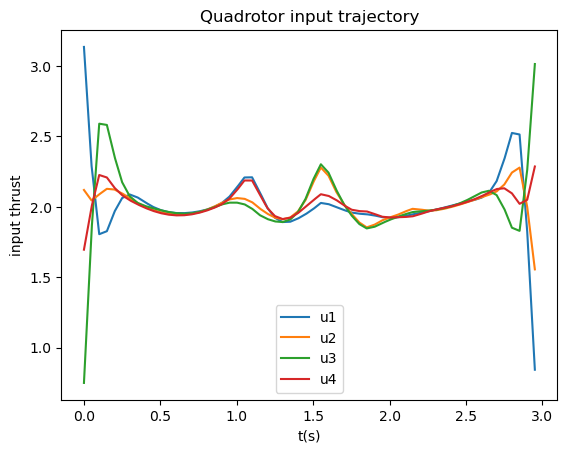

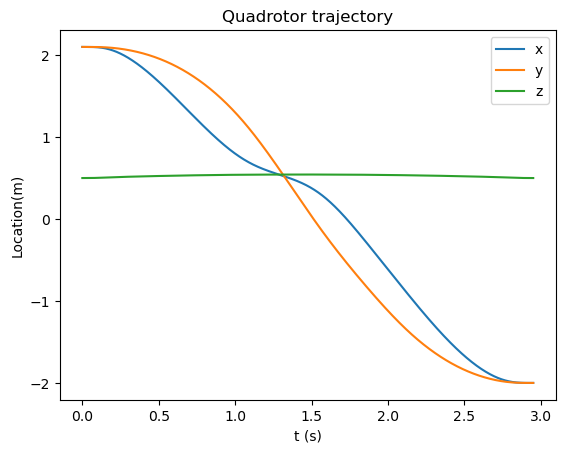

In [ ]:
final_state=[-2,-2,0.5,0,0,0,0,0,0,0,0,0]
def create_scene():
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    builder = DiagramBuilder()
    quad_plant = builder.AddSystem(QuadrotorPlant())
    plant, scene_graph= AddMultibodyPlantSceneGraph(builder, time_step=0.002)
    parser = Parser(plant,scene_graph)
    QuadrotorGeometry.AddToBuilder(builder, quad_plant.get_output_port(0), scene_graph)

    # Loading models.
    # Load the table top and the cylinder we created.
    parser.AddModelsFromString(cylinder_sdf, "sdf")
    parser.AddModelsFromString(cylinder_sdf1, "sdf")
    parser.AddModelsFromString(cylinder_sdf2, "sdf")
    parser.AddModelsFromString(cylinder_sdf3, "sdf")
    parser.AddModelsFromString(cylinder_sdf4, "sdf")
    parser.AddModelsFromString(cylinder_sdf5, "sdf")
    parser.AddModelsFromString(cylinder_sdf6, "sdf")
    parser.AddModelsFromString(cylinder_sdf7, "sdf")
    parser.AddModels(table_top_sdf_file)

    # Weld the table to the world so that it's fixed during the simulation.
    table_frame = plant.GetFrameByName("table_top_center")
    plant.WeldFrames(plant.world_frame(), table_frame)

    cylinder_frame=plant.GetFrameByName("cylinder_base")
    X_WC = RigidTransform(RotationMatrix.Identity(), [1,0,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame,X_WC)

    cylinder_frame1=plant.GetFrameByName("cylinder_base1")
    X_WC1 = RigidTransform(RotationMatrix.Identity(), [0,1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame1,X_WC1)


    cylinder_frame2=plant.GetFrameByName("cylinder_base2")
    X_WC2 = RigidTransform(RotationMatrix.Identity(), [0,0,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame2,X_WC2)

    cylinder_frame3=plant.GetFrameByName("cylinder_base3")
    X_WC3 = RigidTransform(RotationMatrix.Identity(), [0,-1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame3,X_WC3)

    cylinder_frame4=plant.GetFrameByName("cylinder_base4")
    X_WC4 = RigidTransform(RotationMatrix.Identity(), [1,1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame4,X_WC4)

    cylinder_frame5=plant.GetFrameByName("cylinder_base5")
    X_WC5 = RigidTransform(RotationMatrix.Identity(), [-1.1,-1.1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame5,X_WC5)

    cylinder_frame6=plant.GetFrameByName("cylinder_base6")
    X_WC6 = RigidTransform(RotationMatrix.Identity(), [-1.1,1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame6,X_WC6)

    cylinder_frame7=plant.GetFrameByName("cylinder_base7")
    X_WC7 = RigidTransform(RotationMatrix.Identity(), [1,-1.1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame7,X_WC7)

    # Finalize the plant after loading the scene.
    plant.Finalize()
    #plant_context = plant.CreateDefaultContext()
    # Add visualization to see the geometries.
    MeshcatVisualizer.AddToBuilder(builder,scene_graph, meshcat)
    
    #AddDefaultVisualization(builder=builder, meshcat=meshcat)
    u_trajectory, states, is_suc= get_col_traj(initial_state=[2.1,2.1,.5,0,0,0,0,0,0,0,0,0],goal_state=[-2,-2,0.5,0,0,0,0,0,0,0,0,0])
    #traj_source = builder.AddSystem(TrajectorySource(u_trajectory))
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.x0 = states
    options.u0 = u_trajectory

    

    Q = np.diag([20.,20.,20.,20.,20.,20.,20.,20.,1.,1.,1.,1.])

        #final cost matrix
    options.Qf = Q
    R = np.diag([10,10,10,10])
    quad_context = quad_plant.CreateDefaultContext()
    quad_plant.get_input_port(0).FixValue(quad_context, np.repeat(quad_plant.m()*9.81/4.0,4))

    

    lqr_regulator = MakeFiniteHorizonLinearQuadraticRegulator(quad_plant,
                                                  quad_context,
                                                  t0=options.u0.start_time(),
                                                  tf=options.u0.end_time(),
                                                  Q=Q,
                                                  R=R,
                                                  options=options)
    
    builder.AddSystem(lqr_regulator)
    builder.Connect(lqr_regulator.get_output_port(0), quad_plant.get_input_port(0))
    builder.Connect(quad_plant.get_output_port(0), lqr_regulator.get_input_port(0))

    input_logger = LogVectorOutput(lqr_regulator.get_output_port(0), builder)
    state_logger = LogVectorOutput(quad_plant.get_output_port(0), builder)
                                            
    #builder.Connect(traj_source.get_output_port(0), quad_plant.get_input_port(0))
    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_context()
    context.SetContinuousState([2.1,2.1,0.5,0,0,0,0,0,0,0,0,0])
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    meshcat.StartRecording()
    simulator.AdvanceTo(u_trajectory.end_time())
    
    meshcat.PublishRecording()

    input_log = input_logger.FindLog(simulator.get_context())
    plt.figure(1)
    # Plotting both the curves simultaneously
    plt.plot(input_log.sample_times(), input_log.data()[0], label='u1')
    plt.plot(input_log.sample_times(), input_log.data()[1], label='u2')
    plt.plot(input_log.sample_times(), input_log.data()[2], label='u3')
    plt.plot(input_log.sample_times(), input_log.data()[3], label='u4')

    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("t(s)")
    plt.ylabel("input thrust")
    plt.title("Quadrotor input trajectory")
    plt.legend()
    plt.show()

    state_log = state_logger.FindLog(simulator.get_context())
    plt.figure(2)
    # Plotting both the curves simultaneously
    plt.plot(state_log.sample_times(), state_log.data()[0],  label='x')
    plt.plot(state_log.sample_times(), state_log.data()[1],  label='y')
    plt.plot(state_log.sample_times(), state_log.data()[2],  label='z')

    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("t (s)")
    plt.ylabel("Location(m)")
    plt.title("Quadrotor trajectory")
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
    # To load the display window
    plt.show()

    
   
    

create_scene()

In [ ]:
start = np.array([2.1, 2.1])  # Start location
goal = np.array([-2, -2])  # Goal location

obstacles = [  # circles parametrized by [x, y, radius]
    np.array([1, 0, 0.41]),
    np.array([0, 1, 0.41]),
    np.array([0, 0, 0.41]),
    np.array([0, -1, 0.41]),
    np.array([1, 1, 0.41]),
    np.array([-1.1, -1.1, 0.41]),
    np.array([1, -1.1, 0.41]),
    np.array([-1.1,1, 0.41]),
]

bounds = np.array([-3, 3])  # Bounds in both x and y


    

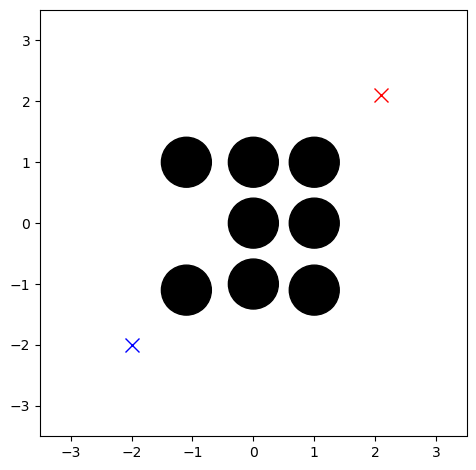

In [ ]:
def plot_scene(obstacle_list, start, goal):
    ax = plt.gca()
    for o in obstacle_list:
        circle = plt.Circle((o[0], o[1]), o[2], color="k")
        ax.add_artist(circle)
    plt.axis([bounds[0] - 0.5, bounds[1] + 0.5, bounds[0] - 0.5, bounds[1] + 0.5])
    plt.plot(start[0], start[1], "xr", markersize=10)
    plt.plot(goal[0], goal[1], "xb", markersize=10)
    plt.gca().set_aspect("equal")


plt.figure()
plot_scene(obstacles, start, goal)
plt.tight_layout()

In [ ]:
class RRT:
    class Node:
        def __init__(self, p):
            self.p = np.array(p)
            self.parent = None

    def __init__(
        self,
        start,
        goal,
        obstacle_list,
        bounds,
        max_extend_length=0.5,
        path_resolution=0.1,
        goal_sample_rate=0.1,
        max_iter=300,
    ):
        self.start = self.Node(start)
        self.goal = self.Node(goal)
        self.bounds = bounds
        self.max_extend_length = max_extend_length
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []

    def plan(self):
        """Plans the path from start to goal while avoiding obstacles"""
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # modify here:
            # 1) Create a random node (rnd_node) inside
            # the bounded environment
            # 2) Find nearest node (nearest_node)
            # 3) Get new node (new_node) by connecting
            # rnd_node and nearest_node. Hint: steer
            # 4) If the path between new_node and the
            # nearest node is not in collision, add it to the node_list

            # Don't need to modify beyond here
            # If the new_node is very close to the goal, connect it
            # directly to the goal and return the final path
            rnd_node = self.get_random_node()
            nearest_node = self.get_nearest_node(self.node_list, rnd_node)
            new_node = self.steer(nearest_node, rnd_node, self.max_extend_length)
            if not self.collision(nearest_node, new_node, self.obstacle_list):
                self.node_list.append(new_node)
                self.node_list[-1].parent = nearest_node

            if self.dist_to_goal(self.node_list[-1].p) <= self.max_extend_length:
                final_node = self.steer(
                    self.node_list[-1], self.goal, self.max_extend_length
                )
                if not self.collision(
                    final_node, self.node_list[-1], self.obstacle_list
                ):
                    return self.final_path(len(self.node_list) - 1)
        return None  # cannot find path

    def steer(self, from_node, to_node, max_extend_length=np.inf):
        """Connects from_node to a new_node in the direction of to_node
        with maximum distance max_extend_length
        """
        new_node = self.Node(to_node.p)
        d = from_node.p - to_node.p
        dist = np.linalg.norm(d)
        if dist > max_extend_length:
            # rescale the path to the maximum extend_length
            new_node.p = from_node.p - d / dist * max_extend_length
        new_node.parent = from_node
        return new_node

    def dist_to_goal(self, p):
        """Distance from p to goal"""
        return np.linalg.norm(p - self.goal.p)

    def get_random_node(self):
        """Sample random node inside bounds or sample goal point"""
        if np.random.rand() > self.goal_sample_rate:
            # Sample random point inside boundaries
            rnd = self.Node(
                np.random.rand(2) * (self.bounds[1] - self.bounds[0]) + self.bounds[0]
            )
        else:
            # Select goal point
            rnd = self.Node(self.goal.p)
        return rnd

    @staticmethod
    def get_nearest_node(node_list, node):
        """Find the nearest node in node_list to node"""
        dlist = [np.sum(np.square((node.p - n.p))) for n in node_list]
        minind = dlist.index(min(dlist))
        return node_list[minind]

    @staticmethod
    def collision(node1, node2, obstacle_list):
        """Check whether the path connecting node1 and node2
        is in collision with anyting from the obstacle_list
        """
        p1 = node2.p
        p2 = node1.p
        for o in obstacle_list:
            center_circle = o[0:2]
            radius = o[2]
            d12 = p2 - p1  # the directional vector from p1 to p2
            # defines the line v(t) := p1 + d12*t going through p1=v(0) and p2=v(1)
            d1c = center_circle - p1  # the directional vector from circle to p1
            # t is where the line v(t) and the circle are closest
            # Do not divide by zero if node1.p and node2.p are the same.
            # In that case this will still check for collisions with circles
            t = d12.dot(d1c) / (d12.dot(d12) + 1e-7)
            t = max(0, min(t, 1))  # Our line segment is bounded 0<=t<=1
            d = p1 + d12 * t  # The point where the line segment and circle are closest
            is_collide = np.sum(np.square(center_circle - d)) < radius**2
            if is_collide:
                return True  # is in collision
        return False  # is not in collision

    def final_path(self, goal_ind):
        """Compute the final path from the goal node to the start node"""
        path = [self.goal.p]
        node = self.node_list[goal_ind]
        # modify here: Generate the final path from the goal node to the start node.
        # We will check that path[0] == goal and path[-1] == start
        while node.parent:
            path.append(node.p)
            node = node.parent
        path.append(self.start.p)
        return path

    def draw_graph(self):
        for node in self.node_list:
            if node.parent:
                plt.plot(
                    [node.p[0], node.parent.p[0]],
                    [node.p[1], node.parent.p[1]],
                    "-g",
                )

In [ ]:

rrt = RRT(start=start, goal=goal, bounds=bounds, obstacle_list=obstacles)
path_rrt = rrt.plan()

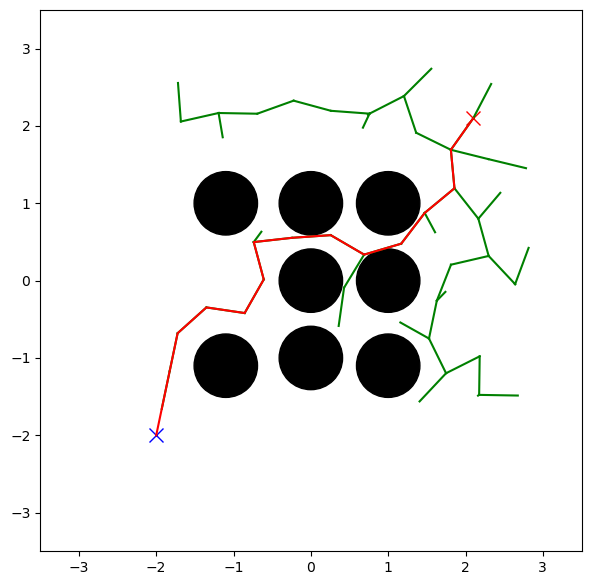

In [ ]:
plt.figure(figsize=(6, 6))
plot_scene(obstacles, start, goal)
rrt.draw_graph()
if path_rrt is None:
    print("No viable path found")
else:
    plt.plot([x for (x, y) in path_rrt], [y for (x, y) in path_rrt], "-r")
plt.tight_layout()

In [ ]:
class RRTStar(RRT):
    class Node(RRT.Node):
        def __init__(self, p):
            super().__init__(p)
            self.cost = 0.0

    def __init__(
        self,
        start,
        goal,
        obstacle_list,
        bounds,
        max_extend_length=0.4,
        path_resolution=0.01,
        goal_sample_rate=0.0,
        max_iter=300,
        connect_circle_dist=20.0,
    ):
        super().__init__(
            start,
            goal,
            obstacle_list,
            bounds,
            max_extend_length,
            path_resolution,
            goal_sample_rate,
            max_iter,
        )
        self.connect_circle_dist = connect_circle_dist
        self.goal = self.Node(goal)

    def plan(self):
        """Plans the path from start to goal while avoiding obstacles"""
        self.node_list = [self.start]
        for i in range(self.max_iter):
            # Create a random node inside the bounded environment
            rnd = self.get_random_node()
            # Find nearest node
            nearest_node = self.get_nearest_node(self.node_list, rnd)
            # Get new node by connecting rnd_node and nearest_node
            new_node = self.steer(nearest_node, rnd, self.max_extend_length)
            # If path between new_node and nearest node is not in collision:
            if not self.collision(new_node, nearest_node, self.obstacle_list):
                near_inds = self.near_nodes_inds(new_node)
                # Connect the new node to the best parent in near_inds
                new_node = self.choose_parent(new_node, near_inds)
                self.node_list.append(new_node)
                # Rewire the nodes in the proximity of new_node if it improves their costs
                self.rewire(new_node, near_inds)
        last_index, min_cost = self.best_goal_node_index()
        if last_index:
            return self.final_path(last_index), min_cost
        return None, min_cost

    def choose_parent(self, new_node, near_inds):
        """Set new_node.parent to the lowest resulting cost parent in near_inds and
        new_node.cost to the corresponding minimal cost
        """
        min_cost = np.inf
        best_near_node = None
        # modify here: Go through all near nodes and evaluate them as potential parent nodes by
        # 1) checking whether a connection would result in a collision,
        # 2) evaluating the cost of the new_node if it had that near node as a parent,
        # 3) picking the parent resulting in the lowest cost and updating
        #    the cost of the new_node to the minimum cost.
        for i in near_inds:
            parent = self.node_list[i]
            if not self.collision(parent, new_node, self.obstacle_list):        
                cost = self.new_cost(parent, new_node)
                if cost < min_cost:
                    min_cost = cost
                    best_near_node = parent
        # Don't need to modify beyond here
        new_node.cost = min_cost
        new_node.parent = best_near_node
        return new_node

    def rewire(self, new_node, near_inds):
        """Rewire near nodes to new_node if this will result in a lower cost"""
        # modify here: Go through all near nodes and check whether rewiring them
        # to the new_node would:
        # A) Not cause a collision and
        # B) reduce their own cost.
        # If A and B are true, update the cost and parent properties of the node.

        # Don't need to modify beyond here
        for i in near_inds:
            node = self.node_list[i]
            if not self.collision(new_node, node, self.obstacle_list):        
                cost = self.new_cost(new_node, node)
                if cost < node.cost:
                    node.cost = cost
                    node.parent = new_node
        # Don't need to modify beyond here
        self.propagate_cost_to_leaves(new_node)

    def best_goal_node_index(self):
        """Find the lowest cost node to the goal"""
        min_cost = np.inf
        best_goal_node_idx = None
        for i in range(len(self.node_list)):
            node = self.node_list[i]
            # Has to be in close proximity to the goal
            if self.dist_to_goal(node.p) <= self.max_extend_length:
                # Connection between node and goal needs to be collision free
                if not self.collision(self.goal, node, self.obstacle_list):
                    # The final path length
                    cost = node.cost + self.dist_to_goal(node.p)
                    if node.cost + self.dist_to_goal(node.p) < min_cost:
                        # Found better goal node!
                        min_cost = cost
                        best_goal_node_idx = i
        return best_goal_node_idx, min_cost

    def near_nodes_inds(self, new_node):
        """Find the nodes in close proximity to new_node"""
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * np.sqrt((np.log(nnode) / nnode))
        dlist = [np.sum(np.square((node.p - new_node.p))) for node in self.node_list]
        near_inds = [dlist.index(i) for i in dlist if i <= r**2]
        return near_inds

    def new_cost(self, from_node, to_node):
        """to_node's new cost if from_node were the parent"""
        d = np.linalg.norm(from_node.p - to_node.p)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):
        """Recursively update the cost of the nodes"""
        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)

In [ ]:
rrt_star = RRTStar(start=start, goal=goal, bounds=bounds, obstacle_list=obstacles)
path_rrt_star, min_cost = rrt_star.plan()
print("Minimum cost: {}".format(min_cost))


# Check the cost
def path_cost(path):
    return sum(np.linalg.norm(path[i] - path[i + 1]) for i in range(len(path) - 1))


if path_rrt_star:
    print("Length of the found path: {}".format(path_cost(path_rrt_star)))

print(path_rrt_star)

Minimum cost: 6.3344423063114625
Length of the found path: 6.334442306311463
[array([-2, -2]), array([-1.95995603, -1.6405616 ]), array([-0.98514015, -0.08637001]), array([-0.50239312,  0.34246547]), array([1.2266622 , 0.61598989]), array([1.51661156, 0.89154273]), array([2.1, 2.1])]


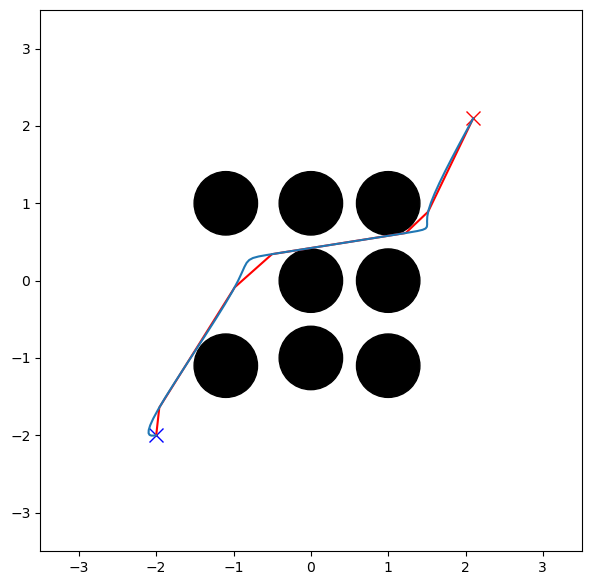

In [ ]:
plt.figure(figsize=(6, 6))
plot_scene(obstacles, start, goal)
if path_rrt_star is None:
    print("No viable path found")
else:
    plt.plot([i for (i, j) in path_rrt_star], [j for (i, j) in path_rrt_star], "-r")
plt.tight_layout()
x,y=sample_trajectory(path_rrt_star,50)
plt.plot(x,y)


In [ ]:
import numpy as np
import math
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

#modified from https://github.com/mschoder/vehicle_mpc/blob/main/trajectory_gen.py
def sample_trajectory(ctrl_pts,n):
    x = [p[0] for p in ctrl_pts]
    y = [p[1] for p in ctrl_pts]

    cx, cy = calc_c2_traj(x, y)

    total_length = 0
    for i in range(cx.c.shape[1]):
        coeffs_x = np.flip(cx.c[:, i])
        coeffs_y = np.flip(cy.c[:, i])
        slen = calc_spline_length(coeffs_x, coeffs_y)
        total_length += slen

    nsteps = n
    # tvec = np.arange(0, len(x)-1+dt, dt)
    tvec = np.linspace(0, len(x)-1, nsteps)
    xs = cx(tvec)
    ys = cy(tvec)

    return xs, ys

def calc_c2_traj(x, y,eps=0.0005,):

    # Start with euclidean dist as slen approx for first and last segments
    slen_start = np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2)
    slen_end = np.sqrt((x[-1] - x[-2])**2 + (y[-1] - y[-2])**2)
    while True:
        cx, cy = gen_c2_spline(x, y)
        coeffs_x_start = np.flip(cx.c[:, 0])
        coeffs_y_start = np.flip(cy.c[:, 0])
        coeffs_x_end = np.flip(cx.c[:, -1])
        coeffs_y_end = np.flip(cy.c[:, -1])
        slen_start_new = calc_spline_length(coeffs_x_start, coeffs_y_start)
        slen_end_new = calc_spline_length(coeffs_x_end, coeffs_y_end)

        if abs(slen_start_new - slen_start) < eps and abs(slen_end_new - slen_end) < eps:
            break
        else:
            slen_start = slen_start_new
            slen_end = slen_end_new
    return cx, cy


def gen_c2_spline(x, y):
    '''
    Generates a C2 continuous spline using scipy CubicSpline lib
    x: np.array of x-coordinate points
    y: np.array of y-coordinate points
    '''

    # define mu, a virtual path variable of length 1 for each spline segment
    assert(len(x) == len(y))
    mu = np.arange(0, len(x), 1.0)

    # build splines
    cs_x = CubicSpline(mu, x,bc_type="natural")
    cs_y = CubicSpline(mu, y,bc_type="natural")
    return cs_x, cs_y




def calc_spline_length(x_coeffs, y_coeffs, n_ips=20):
    '''
    Returns numerically computed length along cubic spline
    x_coeffs: array of 4 x coefficients
    y_coeffs: array of 4 y coefficients
    '''

    t_steps = np.linspace(0.0, 2.0, 20)
    spl_coords = np.zeros((n_ips, 2))

    spl_coords[:, 0] = x_coeffs[0] \
        + x_coeffs[1] * t_steps \
        + x_coeffs[2] * np.power(t_steps, 2) \
        + x_coeffs[3] * np.power(t_steps, 3)
    spl_coords[:, 1] = y_coeffs[0] \
        + y_coeffs[1] * t_steps \
        + y_coeffs[2] * np.power(t_steps, 2) \
        + y_coeffs[3] * np.power(t_steps, 3)

    slength = np.sum(
        np.sqrt(np.sum(np.power(np.diff(spl_coords, axis=0), 2), axis=1)))
    return slength
  
  


In [ ]:
def get_full_state_trajectory(xyz_traj, duration):
        n = xyz_traj.shape[0]
        dt = duration / n

        dts = np.linspace(0,duration,n).reshape(n,1)
        xyz_dot = np.gradient(xyz_traj, axis=0)/dt
        xyz_ddot = np.gradient(xyz_dot, axis=0)/dt

        a = np.copy(xyz_ddot)
        a[:,2] = a[:,2]+9.8
        zB = (a / (np.linalg.norm(a, axis=1).reshape(n,1))).reshape(n,3)
        xC = np.array([1,0,0]).reshape(1,3)
        yB = np.cross(zB, xC)
        yB = yB / np.linalg.norm(yB, axis=1).reshape(n,1)
        xB = np.cross(yB, zB)
        RWB = np.stack((xB, yB, zB)).T

        roll = []
        pitch = []
        yaw = []
        for i in range(n):
            R_mat_drake = RotationMatrix(RWB[:,i,:])
            rpy = RollPitchYaw(R_mat_drake)
            roll.append(rpy.roll_angle())
            pitch.append(rpy.pitch_angle())
            yaw.append(rpy.yaw_angle())

        roll = np.array(roll)
        pitch = np.array(pitch)
        yaw = np.array(yaw)

        roll_dot = np.gradient(roll)/dt
        pitch_dot = np.gradient(pitch)/dt
        yaw_dot = np.gradient(yaw)/dt

        roll[0] = 0
        pitch[0] = 0
        yaw[0] = 0
        roll[-1] = 0
        pitch[-1] = 0
        yaw[-1] = 0
        roll_dot[0] = 0
        pitch_dot[0] = 0
        yaw_dot[0] = 0
        roll_dot[-1] = 0
        pitch_dot[-1] = 0
        yaw_dot[-1] = 0

        full_trajectory = np.zeros((12,n))
        full_trajectory[0:3,:] = xyz_traj.T
        full_trajectory[3,:] = roll
        full_trajectory[4,:] = pitch
        full_trajectory[5,:] = yaw
        full_trajectory[6:9,:] = xyz_dot.T
        full_trajectory[9,:] = roll_dot
        full_trajectory[10,:] = pitch_dot
        full_trajectory[11,:] = yaw_dot
        traj = full_trajectory

        return full_trajectory



In [ ]:
rrt_star = RRTStar(start=start, goal=goal, bounds=bounds, obstacle_list=obstacles)
path_rrt_star, min_cost = rrt_star.plan()

In [ ]:
def get_rrt_traj() :   
    
    x,y=sample_trajectory(path_rrt_star,50)
    result=[]
    for i in range(50):
        result.insert(0,[x[i],y[i],0.5])
    result=np.array(result)
    ref_traj=get_full_state_trajectory(result, 4)
    return ref_traj

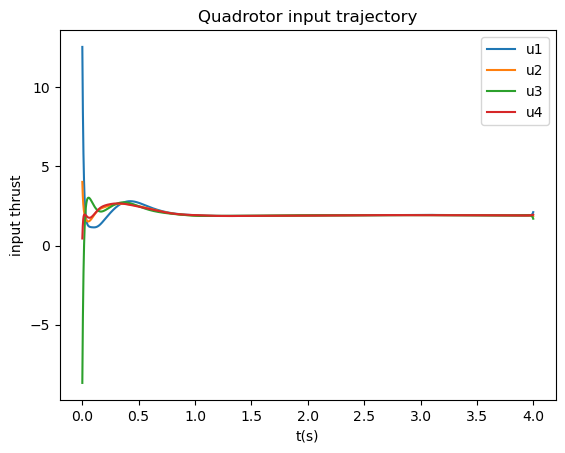

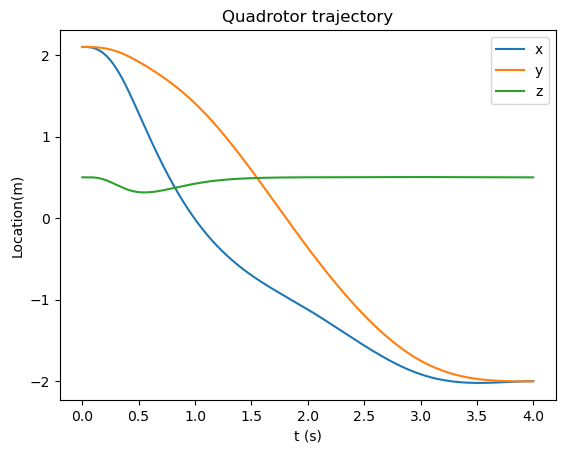

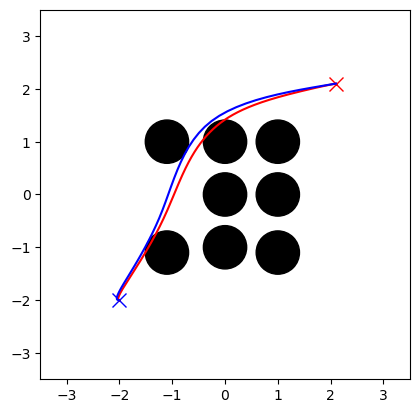

In [ ]:
initial_state = [2.1, 2.1, 0.5, 0., 0., 0., 0., 0., 0., 0., 0., 0.]
final_state=[-2,-2,0.5,0,0,0,0,0,0,0,0,0]
def rrtplanning(initial_state,final_state):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()
    builder = DiagramBuilder()
    quad_plant = builder.AddSystem(QuadrotorPlant())
    plant, scene_graph= AddMultibodyPlantSceneGraph(builder, time_step=0.002)
    parser = Parser(plant,scene_graph)
    QuadrotorGeometry.AddToBuilder(builder, quad_plant.get_output_port(0), scene_graph)

    # Loading models.
    # Load the table top and the cylinder we created.
    parser.AddModelsFromString(cylinder_sdf, "sdf")
    parser.AddModelsFromString(cylinder_sdf1, "sdf")
    parser.AddModelsFromString(cylinder_sdf2, "sdf")
    parser.AddModelsFromString(cylinder_sdf3, "sdf")
    parser.AddModelsFromString(cylinder_sdf4, "sdf")
    parser.AddModelsFromString(cylinder_sdf5, "sdf")
    parser.AddModelsFromString(cylinder_sdf6, "sdf")
    parser.AddModelsFromString(cylinder_sdf7, "sdf")
    parser.AddModels(table_top_sdf_file)

    # Weld the table to the world so that it's fixed during the simulation.
    table_frame = plant.GetFrameByName("table_top_center")
    plant.WeldFrames(plant.world_frame(), table_frame)

    cylinder_frame=plant.GetFrameByName("cylinder_base")
    X_WC = RigidTransform(RotationMatrix.Identity(), [1,0,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame,X_WC)

    cylinder_frame1=plant.GetFrameByName("cylinder_base1")
    X_WC1 = RigidTransform(RotationMatrix.Identity(), [0,1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame1,X_WC1)


    cylinder_frame2=plant.GetFrameByName("cylinder_base2")
    X_WC2 = RigidTransform(RotationMatrix.Identity(), [0,0,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame2,X_WC2)

    cylinder_frame3=plant.GetFrameByName("cylinder_base3")
    X_WC3 = RigidTransform(RotationMatrix.Identity(), [0,-1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame3,X_WC3)

    cylinder_frame4=plant.GetFrameByName("cylinder_base4")
    X_WC4 = RigidTransform(RotationMatrix.Identity(), [1,1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame4,X_WC4)

    cylinder_frame5=plant.GetFrameByName("cylinder_base5")
    X_WC5 = RigidTransform(RotationMatrix.Identity(), [-1.1,-1.1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame5,X_WC5)

    cylinder_frame6=plant.GetFrameByName("cylinder_base6")
    X_WC6 = RigidTransform(RotationMatrix.Identity(), [-1.1,1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame6,X_WC6)

    cylinder_frame7=plant.GetFrameByName("cylinder_base7")
    X_WC7 = RigidTransform(RotationMatrix.Identity(), [1,-1.1,0])
    plant.WeldFrames(plant.world_frame(), cylinder_frame7,X_WC7)

    # Finalize the plant after loading the scene.
    plant.Finalize()
    #plant_context = plant.CreateDefaultContext()
    # Add visualization to see the geometries.

    MeshcatVisualizer.AddToBuilder(builder,scene_graph, meshcat)
    full_trajectory = get_rrt_traj()
    full_trajectory[:,0][6]=0
    full_trajectory[:,0][7]=0
    full_trajectory[:,-1][6]=0
    full_trajectory[:,-1][7]=0

        # Create controller
    traj_src = PiecewisePolynomial.FirstOrderHold(np.linspace(0,4,50), full_trajectory)
    
    #AddDefaultVisualization(builder=builder, meshcat=meshcat)
    #u_trajectory, states = get_col_traj(initial_state=[1.3,1.3,.5,0,0,0,0,0,0,0,0,0],goal_state=[-1.4,-1.4,0.5,0,0,0,0,0,0,0,0,0])
    #traj_source = builder.AddSystem(TrajectorySource(u_trajectory))
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.x0 = traj_src
    quad_context=quad_plant.CreateDefaultContext()
    quad_plant.get_input_port(0).FixValue(quad_context, np.repeat(quad_plant.m()*9.81/4.0,4))
    
    Q = np.diag([20.,20.,20.,20.,20.,20.,20.,20.,1.,1.,1.,1.])
    R = np.diag([1,1,1,1])
    options.Qf = Q
    
    lqr_regulator = MakeFiniteHorizonLinearQuadraticRegulator(quad_plant,
                                                  quad_context,
                                                  t0=0,
                                                  tf=4,
                                                  Q=Q,
                                                  R=R,
                                                  options=options)
    
    builder.AddSystem(lqr_regulator)
    builder.Connect(lqr_regulator.get_output_port(0), quad_plant.get_input_port(0))
    builder.Connect(quad_plant.get_output_port(0), lqr_regulator.get_input_port(0))
    input_logger = LogVectorOutput(lqr_regulator.get_output_port(0), builder)
    state_logger = LogVectorOutput(quad_plant.get_output_port(0), builder)
    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_context()
    context.SetContinuousState(initial_state)
    context.SetTime(0.)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.) 
    meshcat.StartRecording()
    simulator.AdvanceTo(4)
    meshcat.PublishRecording()
    input_log = input_logger.FindLog(simulator.get_context())
    plt.figure(1)
    plt.plot(input_log.sample_times(), input_log.data()[0], label='u1')
    plt.plot(input_log.sample_times(), input_log.data()[1], label='u2')
    plt.plot(input_log.sample_times(), input_log.data()[2], label='u3')
    plt.plot(input_log.sample_times(), input_log.data()[3], label='u4')

    plt.xlabel("t(s)")
    plt.ylabel("input thrust")
    plt.title("Quadrotor input trajectory")
    plt.legend()
    plt.show()

    state_log = state_logger.FindLog(simulator.get_context())
    # Plotting both the curves simultaneously
    plt.plot(state_log.sample_times(), state_log.data()[0],  label='x')
    plt.plot(state_log.sample_times(), state_log.data()[1],  label='y')
    plt.plot(state_log.sample_times(), state_log.data()[2],  label='z')

    plt.xlabel("t (s)")
    plt.ylabel("Location(m)")
    plt.title("Quadrotor trajectory")
    plt.legend()
    plt.show() 

    plt.figure(3)
    plot_scene(obstacles,start,goal) 
    plt.plot(state_log.data()[0],state_log.data()[1],"r-")  
    plt.plot(full_trajectory[0,:],full_trajectory[1,:],"b-")

rrtplanning(initial_state,final_state)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9296033e-5cf2-40d0-8a6b-9fd90aadee5f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>